# Sentiment Classification Model 6

 Trained on IMDB dataset, predicts on WW2 Bunker Reviews

### 1. Import Dependencies

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    Trainer, 
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, f1_score

from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss





### 2. Load Data

In [2]:
df = pd.read_pickle("../data/processed/processed_movie_reviews.pkl")
df.head()

,review,sentiment,clean_text,tokens
0,One of the other reviewers has mentioned that ...,1,One of the other reviewers has mentioned that ...,"{'input_ids': [101, 2028, 1997, 1996, 2060, 15..."
1,A wonderful little production. <br /><br />The...,1,A wonderful little production. The filming tec...,"{'input_ids': [101, 1037, 6919, 2210, 2537, 10..."
2,I thought this was a wonderful way to spend ti...,1,I thought this was a wonderful way to spend ti...,"{'input_ids': [101, 1045, 2245, 2023, 2001, 10..."
3,Basically there's a family where a little boy ...,0,Basically there's a family where a little boy ...,"{'input_ids': [101, 10468, 2045, 1005, 1055, 1..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,Petter Mattei's Love in the Time of Money is a...,"{'input_ids': [101, 9004, 3334, 4717, 7416, 10..."


### 3. Prepare Train/Validation Splits

In [3]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["review"], df["sentiment"], test_size=0.4, random_state=42, stratify=df["sentiment"]
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print("Training samples:", len(train_texts))
print("Validation samples:", len(val_texts))
print("Test samples:", len(test_texts))

Training samples: 30000
Validation samples: 10000
Test samples: 10000


### 4. Create a Dataset Class

In [4]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        # texts and labels can be lists or pd.Series
        self.texts = texts.tolist() if hasattr(texts, "tolist") else texts
        self.labels = labels.tolist() if hasattr(labels, "tolist") else labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

### 5. Instansiate Tokenizer & Dataset

In [5]:
# Tokenizer for the uncased model
tokenizer_uncased = BertTokenizer.from_pretrained("bert-base-uncased")
# Tokenizer for the cased model
tokenizer_cased = BertTokenizer.from_pretrained("bert-base-cased")

# Create datasets for each tokenizer.
train_dataset_uncased = SentimentDataset(train_texts, train_labels, tokenizer_uncased)
val_dataset_uncased = SentimentDataset(val_texts, val_labels, tokenizer_uncased)
test_dataset_uncased = SentimentDataset(test_texts, test_labels, tokenizer_uncased)

train_dataset_cased = SentimentDataset(train_texts, train_labels, tokenizer_cased)
val_dataset_cased = SentimentDataset(val_texts, val_labels, tokenizer_cased)
test_dataset_cased = SentimentDataset(test_texts, test_labels, tokenizer_cased)

### 6. Initialize Model and Trainer

In [6]:
training_args_uncased = TrainingArguments(
    output_dir="outputs_uncased",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="logs_uncased",
    logging_steps=50,
    fp16=True if torch.cuda.is_available() else False
)

training_args_cased = TrainingArguments(
    output_dir="outputs_cased",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="logs_cased",
    logging_steps=50,
    fp16=True if torch.cuda.is_available() else False
)


/cluster/home/askk/.local/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/cluster/home/askk/.local/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### 7. Train

In [7]:
model_uncased = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_cased = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
trainer_uncased = Trainer(
    model=model_uncased,
    args=training_args_uncased,
    train_dataset=train_dataset_uncased,
    eval_dataset=val_dataset_uncased
)

trainer_cased = Trainer(
    model=model_cased,
    args=training_args_cased,
    train_dataset=train_dataset_cased,
    eval_dataset=val_dataset_cased
)

In [9]:
print("Training bert-base-uncased model...")
trainer_uncased.train()

Training bert-base-uncased model...


Epoch,Training Loss,Validation Loss
1,0.296400,0.233284
2,0.137600,0.320224
3,0.060300,0.323376


TrainOutput(global_step=11250, training_loss=0.19302278794050218, metrics={'train_runtime': 1592.2376, 'train_samples_per_second': 56.524, 'train_steps_per_second': 7.066, 'total_flos': 2.36799949824e+16, 'train_loss': 0.19302278794050218, 'epoch': 3.0})

In [10]:
print("Training bert-base-cased model...")
trainer_cased.train()

Training bert-base-cased model...


Epoch,Training Loss,Validation Loss
1,0.313300,0.270315
2,0.183500,0.319120
3,0.112300,0.337604


TrainOutput(global_step=11250, training_loss=0.23029671374956767, metrics={'train_runtime': 1487.2043, 'train_samples_per_second': 60.516, 'train_steps_per_second': 7.565, 'total_flos': 2.36799949824e+16, 'train_loss': 0.23029671374956767, 'epoch': 3.0})

In [11]:
# Uncased predictions
predictions_uncased = trainer_uncased.predict(test_dataset_uncased)
pred_labels_uncased = predictions_uncased.predictions.argmax(axis=1)

# Cased predictions
predictions_cased = trainer_cased.predict(test_dataset_cased)
pred_labels_cased = predictions_cased.predictions.argmax(axis=1)


=== Model Comparison ===
bert-base-uncased -> Accuracy: 0.9367, F1 (macro): 0.9367
bert-base-cased   -> Accuracy: 0.9299, F1 (macro): 0.9299

Classification Report (Uncased):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5000
           1       0.94      0.94      0.94      5000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Classification Report (Cased):
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5000
           1       0.93      0.93      0.93      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Number of test samples where the models disagree: 498
Examples of disagreements:


,review,label,pred_uncased,pred_cased
21065,STAR RATING: ***** Saturday Night **** Friday ...,0,1,0
31445,"Ok, so, this is coming a few weeks late, but i...",1,0,1
24070,After watching this film I experienced a new s...,1,1,0
46495,I got a good laugh reading all the idiotic com...,1,0,1
7145,i've just read the most recent remarks about t...,1,1,0
20726,It is more a subtle story of the fact that in ...,1,0,1
2902,So.. what can I tell you about this movie. If ...,0,0,1
5189,The new voices scare me! Kuzco doesn't have to...,1,0,1
31834,This is a movie that demonstrates that mood an...,0,1,0
11521,"Steven Segal has done some awful films, but th...",0,0,1


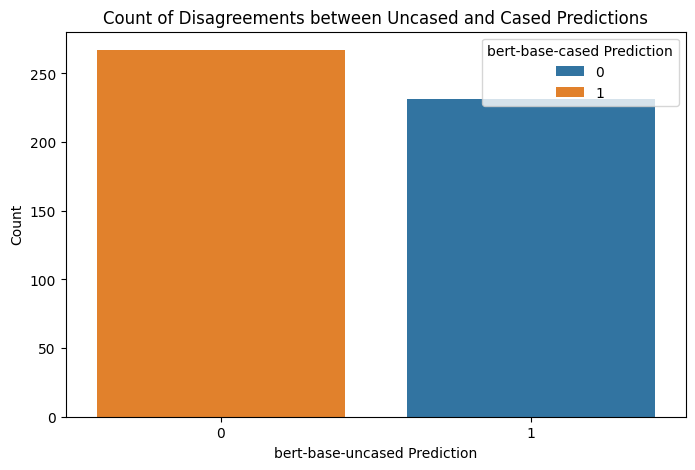

In [12]:
# Create a DataFrame for the test set
df_test = pd.DataFrame({
    "review": test_texts,   # The text of the review
    "label": test_labels    # The true label
})

# Add columns for predictions from both models
df_test["pred_uncased"] = pred_labels_uncased
df_test["pred_cased"] = pred_labels_cased

# Calculate metrics for each model
acc_uncased = accuracy_score(df_test["label"], df_test["pred_uncased"])
f1_uncased = f1_score(df_test["label"], df_test["pred_uncased"], average="macro")

acc_cased = accuracy_score(df_test["label"], df_test["pred_cased"])
f1_cased = f1_score(df_test["label"], df_test["pred_cased"], average="macro")

print("=== Model Comparison ===")
print(f"bert-base-uncased -> Accuracy: {acc_uncased:.4f}, F1 (macro): {f1_uncased:.4f}")
print(f"bert-base-cased   -> Accuracy: {acc_cased:.4f}, F1 (macro): {f1_cased:.4f}\n")

# Optional: Print a detailed classification report for each
print("Classification Report (Uncased):")
print(classification_report(df_test["label"], df_test["pred_uncased"]))
print("Classification Report (Cased):")
print(classification_report(df_test["label"], df_test["pred_cased"]))

# Identify rows where the two models disagree
df_diff = df_test[df_test["pred_uncased"] != df_test["pred_cased"]]
print(f"Number of test samples where the models disagree: {len(df_diff)}")

# Display a few examples of disagreements
print("Examples of disagreements:")
display(df_diff[["review", "label", "pred_uncased", "pred_cased"]].head(10))

# Visualize the disagreement distribution using a count plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_diff, x="pred_uncased", hue="pred_cased")
plt.title("Count of Disagreements between Uncased and Cased Predictions")
plt.xlabel("bert-base-uncased Prediction")
plt.ylabel("Count")
plt.legend(title="bert-base-cased Prediction")
plt.show()


### Bert-base-uncased prediction on ww2 sample dataset

In [13]:

# -----------------------------
# 1. Data Preparation
# -----------------------------
df_train = pd.read_pickle("../data/processed/bunker_reviews_fine_tuning.pkl")
print("Original training set:", len(df_train), "reviews")

# Filter out neutral reviews; keep only "positive" and "negative"
df_train = df_train[df_train["manual_classification"].isin(["positive", "negative"])].copy()
print("Filtered training set (only positive and negative):", len(df_train), "reviews")

# Map labels: negative → 0, positive → 1
label_mapping = {"negative": 0, "positive": 1}
df_train["binary_label"] = df_train["manual_classification"].map(label_mapping)

# Extract texts and labels
train_texts = df_train["clean_text"].tolist()
train_labels = df_train["binary_label"].tolist()

# Split into training and validation sets (60/20/20 split)
train_texts_split, val_texts_split, train_labels_split, val_labels_split = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)
print("Training samples:", len(train_texts_split))
print("Validation samples:", len(val_texts_split))

# -----------------------------
# 2. Compute Class Weights
# -----------------------------
classes = np.unique(train_labels_split)
class_weights = compute_class_weight("balanced", classes=classes, y=train_labels_split)
print("Class weights:", class_weights)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# -----------------------------
# 3. Define a Custom Dataset Class
# -----------------------------
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts if isinstance(texts, list) else texts.tolist()
        self.labels = labels if isinstance(labels, list) else labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# -----------------------------
# 4. Define a Custom Trainer with Weighted Loss
# -----------------------------
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Remove labels from inputs and get them separately
        labels = inputs.pop("labels")
        outputs = model(**inputs)  # forward pass
        logits = outputs.logits     # model predictions

        # Create a weighted CrossEntropyLoss using the computed class weights
        loss_fct = CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# -----------------------------
# 5. Create Tokenizer and Datasets
# -----------------------------
tokenizer_uncased = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = SentimentDataset(train_texts_split, train_labels_split, tokenizer_uncased)
val_dataset = SentimentDataset(val_texts_split, val_labels_split, tokenizer_uncased)

# -----------------------------
# 6. Set Up Training Arguments
# -----------------------------
training_args = TrainingArguments(
    output_dir="outputs_bunker_binary_uncased",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",  # Note: will be deprecated in future versions; use eval_strategy later.
    save_strategy="epoch",
    logging_steps=50,
    learning_rate=2e-5,
    fp16=True if torch.cuda.is_available() else False
)

# -----------------------------
# 7. Load Model
# -----------------------------
model_uncased = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# -----------------------------
# 8. Initialize Custom Trainer and Fine-Tune
# -----------------------------
trainer_uncased = WeightedTrainer(
    model=model_uncased,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

print("Fine-tuning bert-base-uncased on binary bunker reviews with class weighting...")
trainer_uncased.train()
trainer_uncased.save_model("outputs_bunker_binary_uncased/final_model")


Original training set: 773 reviews
Filtered training set (only positive and negative): 654 reviews
Training samples: 523
Validation samples: 131
Class weights: [7.26388889 0.53696099]


/cluster/home/askk/.local/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning bert-base-uncased on binary bunker reviews with class weighting...


Epoch,Training Loss,Validation Loss
1,0.574400,0.752057
2,0.301000,0.637851
3,0.075800,0.674478


In [23]:
model_uncased = BertForSequenceClassification.from_pretrained("outputs_bunker_binary_uncased/final_model", num_labels=2)
tokenizer_uncased = BertTokenizer.from_pretrained("bert-base-uncased")

# Load the test dataset (this may contain all reviews including neutral)
df_test = pd.read_pickle("../data/processed/bunker_reviews_test_set.pkl")
print("Original test set:", len(df_test), "reviews")

# Filter the test set to only include reviews with manual classifications "positive" or "negative"
df_test_filtered = df_test[df_test["manual_classification"].isin(["positive", "negative"])].copy()
print("Filtered test set (only positive and negative):", len(df_test_filtered), "reviews")

# Map labels in the test set for evaluation (if manual_classification exists)
df_test_filtered["binary_label"] = df_test_filtered["manual_classification"].map(label_mapping)

# Prepare the texts and true labels
test_texts = df_test_filtered["clean_text"].tolist()
true_labels = df_test_filtered["binary_label"].tolist()

# Define an inference dataset
class InferenceDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts if isinstance(texts, list) else texts.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze()
        }

inference_dataset = InferenceDataset(test_texts, tokenizer_uncased)

# Set up evaluation TrainingArguments
eval_training_args = TrainingArguments(
    output_dir="outputs_bunker_binary_uncased",
    per_device_eval_batch_size=8
)

# Initialize Trainer (we only need the model and the arguments for prediction)
trainer = Trainer(
    model=model_uncased,
    args=eval_training_args
)

# Get predictions
predictions_output = trainer.predict(inference_dataset)
logits = predictions_output.predictions  # shape: (num_samples, 2)
probs = F.softmax(torch.tensor(logits), dim=1).numpy()

# Map binary predictions to string labels (0: negative, 1: positive)
label_mapping_str = {0: "negative", 1: "positive"}
final_preds = [label_mapping_str[p.argmax()] for p in probs]

# Add predictions to the test DataFrame
df_test_filtered["predicted_sentiment"] = final_preds

# Optionally reorder columns (adjust if necessary)
df_test_filtered = df_test_filtered[["clean_text", "manual_classification", "predicted_sentiment", "tokens"]]

# Save predictions to CSV
df_test_filtered.to_csv("../data/processed/bunker_predictions_binary.csv", index=False)
print("Predictions saved to ../data/processed/bunker_predictions_binary.csv")

# Evaluate performance (if gold labels are available)
true_labels_str = [label_mapping_str[label] for label in true_labels]
accuracy = accuracy_score(true_labels_str, final_preds)

print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(df_test_filtered["manual_classification"], df_test_filtered["predicted_sentiment"], labels=["positive", "negative"])
print("Confusion Matrix:")
print(cm)

report = classification_report(df_test_filtered["manual_classification"], df_test_filtered["predicted_sentiment"], labels=["positive", "negative"])
print("Classification Report:")
print(report)


Original test set: 194 reviews
Filtered test set (only positive and negative): 172 reviews


Predictions saved to ../data/processed/bunker_predictions_binary.csv
Accuracy: 0.9767
Confusion Matrix:
[[154   2]
 [  2  14]]
Classification Report:
              precision    recall  f1-score   support

    positive       0.99      0.99      0.99       156
    negative       0.88      0.88      0.88        16

    accuracy                           0.98       172
   macro avg       0.93      0.93      0.93       172
weighted avg       0.98      0.98      0.98       172



### Bert-base-cased prediction on ww2 sample dataset 

In [21]:

# -----------------------------
# 1. Data Preparation
# -----------------------------
df_train = pd.read_pickle("../data/processed/bunker_reviews_fine_tuning.pkl")
print("Original training set:", len(df_train), "reviews")

# Filter out neutral reviews; keep only "positive" and "negative"
df_train = df_train[df_train["manual_classification"].isin(["positive", "negative"])].copy()
print("Filtered training set (only positive and negative):", len(df_train), "reviews")

# Map labels: negative → 0, positive → 1
label_mapping = {"negative": 0, "positive": 1}
df_train["binary_label"] = df_train["manual_classification"].map(label_mapping)

# Extract texts and labels
train_texts = df_train["clean_text"].tolist()
train_labels = df_train["binary_label"].tolist()

# Split into training and validation sets (60/20/20 split)
train_texts_split, val_texts_split, train_labels_split, val_labels_split = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)
print("Training samples:", len(train_texts_split))
print("Validation samples:", len(val_texts_split))

# -----------------------------
# 2. Compute Class Weights
# -----------------------------
classes = np.unique(train_labels_split)
class_weights = compute_class_weight("balanced", classes=classes, y=train_labels_split)
print("Class weights:", class_weights)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# -----------------------------
# 3. Define a Custom Dataset Class
# -----------------------------
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts if isinstance(texts, list) else texts.tolist()
        self.labels = labels if isinstance(labels, list) else labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# -----------------------------
# 4. Define a Custom Trainer with Weighted Loss
# -----------------------------
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Remove labels from inputs and get them separately
        labels = inputs.pop("labels")
        outputs = model(**inputs)  # forward pass
        logits = outputs.logits     # model predictions

        # Create a weighted CrossEntropyLoss using the computed class weights
        loss_fct = CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# -----------------------------
# 5. Create Tokenizer and Datasets
# -----------------------------
tokenizer_uncased = BertTokenizer.from_pretrained("bert-base-cased")
train_dataset = SentimentDataset(train_texts_split, train_labels_split, tokenizer_uncased)
val_dataset = SentimentDataset(val_texts_split, val_labels_split, tokenizer_uncased)

# -----------------------------
# 6. Set Up Training Arguments
# -----------------------------
training_args = TrainingArguments(
    output_dir="outputs_bunker_binary_cased",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",  # Note: will be deprecated in future versions; use eval_strategy later.
    save_strategy="epoch",
    logging_steps=50,
    learning_rate=2e-5,
    fp16=True if torch.cuda.is_available() else False
)

# -----------------------------
# 7. Load Model
# -----------------------------
model_uncased = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

# -----------------------------
# 8. Initialize Custom Trainer and Fine-Tune
# -----------------------------
trainer_uncased = WeightedTrainer(
    model=model_uncased,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

print("Fine-tuning bert-base-cased on binary bunker reviews with class weighting...")
trainer_uncased.train()
trainer_uncased.save_model("outputs_bunker_binary_cased/final_model")


Original training set: 773 reviews
Filtered training set (only positive and negative): 654 reviews
Training samples: 523
Validation samples: 131
Class weights: [7.26388889 0.53696099]


/cluster/home/askk/.local/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning bert-base-cased on binary bunker reviews with class weighting...


Epoch,Training Loss,Validation Loss
1,0.608100,0.586244
2,0.463700,0.729826
3,0.093900,0.607110


In [22]:
model_uncased = BertForSequenceClassification.from_pretrained("outputs_bunker_binary_cased/final_model", num_labels=2)
tokenizer_uncased = BertTokenizer.from_pretrained("bert-base-cased")

# Load the test dataset (this may contain all reviews including neutral)
df_test = pd.read_pickle("../data/processed/bunker_reviews_test_set.pkl")
print("Original test set:", len(df_test), "reviews")

# Filter the test set to only include reviews with manual classifications "positive" or "negative"
df_test_filtered = df_test[df_test["manual_classification"].isin(["positive", "negative"])].copy()
print("Filtered test set (only positive and negative):", len(df_test_filtered), "reviews")

# Map labels in the test set for evaluation (if manual_classification exists)
df_test_filtered["binary_label"] = df_test_filtered["manual_classification"].map(label_mapping)

# Prepare the texts and true labels
test_texts = df_test_filtered["clean_text"].tolist()
true_labels = df_test_filtered["binary_label"].tolist()

# Define an inference dataset
class InferenceDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts if isinstance(texts, list) else texts.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze()
        }

inference_dataset = InferenceDataset(test_texts, tokenizer_uncased)

# Set up evaluation TrainingArguments
eval_training_args = TrainingArguments(
    output_dir="outputs_bunker_binary_cased",
    per_device_eval_batch_size=8
)

# Initialize Trainer (we only need the model and the arguments for prediction)
trainer = Trainer(
    model=model_uncased,
    args=eval_training_args
)

# Get predictions
predictions_output = trainer.predict(inference_dataset)
logits = predictions_output.predictions  # shape: (num_samples, 2)
probs = F.softmax(torch.tensor(logits), dim=1).numpy()

# Map binary predictions to string labels (0: negative, 1: positive)
label_mapping_str = {0: "negative", 1: "positive"}
final_preds = [label_mapping_str[p.argmax()] for p in probs]

# Add predictions to the test DataFrame
df_test_filtered["predicted_sentiment"] = final_preds

# Optionally reorder columns (adjust if necessary)
df_test_filtered = df_test_filtered[["clean_text", "manual_classification", "predicted_sentiment", "tokens"]]

# Save predictions to CSV
df_test_filtered.to_csv("../data/processed/bunker_predictions_binary.csv", index=False)
print("Predictions saved to ../data/processed/bunker_predictions_binary.csv")

# Evaluate performance (if gold labels are available)
true_labels_str = [label_mapping_str[label] for label in true_labels]
accuracy = accuracy_score(true_labels_str, final_preds)
print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(df_test_filtered["manual_classification"], df_test_filtered["predicted_sentiment"], labels=["positive", "negative"])
print("Confusion Matrix:")
print(cm)

report = classification_report(df_test_filtered["manual_classification"], df_test_filtered["predicted_sentiment"], labels=["positive", "negative"])
print("Classification Report:")
print(report)


Original test set: 194 reviews
Filtered test set (only positive and negative): 172 reviews


Predictions saved to ../data/processed/bunker_predictions_binary.csv
Accuracy: 0.9767
Confusion Matrix:
[[155   1]
 [  3  13]]
Classification Report:
              precision    recall  f1-score   support

    positive       0.98      0.99      0.99       156
    negative       0.93      0.81      0.87        16

    accuracy                           0.98       172
   macro avg       0.95      0.90      0.93       172
weighted avg       0.98      0.98      0.98       172

